In [6]:
import tensorflow as tf
import tools.datasets.mnist3 as mnist_tools
import tools.datasets.mnistm as mnistm_tools 
import tools.semisup as semisup
import numpy as np
import architectures as arch
from functools import partial

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

import sys

mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')
mnistm_train_images, mnistm_train_labels = mnistm_tools.get_data('train')
mnistm_test_images, mnistm_test_labels = mnistm_tools.get_data('test')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Extracting /home/frankzl/datasets/mnist//train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-labels-idx1-ubyte.gz


In [30]:
# labeled samples used per class
# sup_per_class = 10
sup_per_class = 1280
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 100
# unlabeled samples per batch
unsup_batch_size = 1000
unsup_samples = -1

learning_rate = 1e-4
decay_steps = 9000
decay_factor = 0.33
logit_weight = 1.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/training/mnist-mnistmK/model"

seed = 1

IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
NUM_LABELS = mnist_tools.NUM_LABELS

# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(mnist_train_images, mnist_train_labels,
                        sup_per_class, NUM_LABELS, seed)

visit_weight_envelope = "linear"
visit_weight = 2
visit_weight_envelope_steps = 1
visit_weight_envelope_delay = 500

walker_weight_envelope = "linear"
walker_weight = 10
walker_weight_envelope_steps = 1
walker_weight_envelope_delay = 500

TARGET_SHAPE = mnistm_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

image_shape = IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

sampled_unsup_images = mnistm_train_images
sampled_unsup_labels = mnistm_train_labels

In [31]:
store_dir = "logs/training/mnist-mnistK-s40/model"

In [32]:
from ipywidgets import IntProgress, Layout
from train import apply_envelope

graph = tf.Graph()

with graph.as_default():
    
    unsup_data = up.create_input(sampled_unsup_images, sampled_unsup_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    sup_data,sup_label = up.create_per_class_inputs_v2(sup_by_label, sup_per_batch)
    sup_it             = sup_data.repeat().make_one_shot_iterator()
    sup_it_label       = sup_label.repeat().make_one_shot_iterator()
    
    # Apply augmentation
    def _random_invert(inputs, _):
        randu = tf.random_uniform(
            shape=[sup_per_batch * NUM_LABELS], minval=0.,
            maxval=1.,
            dtype=tf.float32)
        randu = tf.cast(tf.less(randu, 0.5), tf.float32)
        randu = tf.expand_dims(randu, 1)
        randu = tf.expand_dims(randu, 1)
        randu = tf.expand_dims(randu, 1)
        inputs = tf.cast(inputs, tf.float32)
        return tf.abs(inputs - 255 * randu)

    augmentation_function = _random_invert
    
    model_func = partial(
        arch.svhn_model,
        new_shape=new_shape,
        augmentation_function=augmentation_function,
        img_shape=image_shape,
        emb_size=emb_size
    )
    
    model = semisup.SemisupModel(model_func, NUM_LABELS, IMAGE_SHAPE,
                                 test_in=tf.placeholder(np.float32, [None] + TEST_SHAPE, 'test_in')
                                )
    
    t_sup_images, t_sup_labels = tf.concat( sup_it.get_next(), 0), tf.concat( sup_it_label.get_next(), 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    visit_weight = apply_envelope(
        type = visit_weight_envelope,
        step = model.step,
        final_weight = visit_weight,
        growing_steps = visit_weight_envelope_steps,
        delay = visit_weight_envelope_delay
    )
    
    walker_weight = apply_envelope(
        type = walker_weight_envelope,
        step = model.step,
        final_weight = walker_weight,
        growing_steps = walker_weight_envelope_steps,
        delay = walker_weight_envelope_delay
    )
    
    tf.summary.scalar("Weights_Visit", visit_weight)
    tf.summary.scalar("Weight_Walker", walker_weight)
    
    model.add_logit_loss(t_sup_logit, t_sup_labels, weight=logit_weight)
    
    #model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight, walker_weight=walker_weight)
    equality_matrix = tf.equal(tf.reshape(t_sup_labels, [-1, 1]), t_sup_labels)
    equality_matrix = tf.cast(equality_matrix, tf.float32)
    p_target = (equality_matrix / tf.reduce_sum(
        equality_matrix, [1], keepdims=True))

    embedding_dim = t_sup_emb.shape[1]
    reshaped_semb = tf.reshape( t_sup_emb, [-1, 1, embedding_dim] )
    reshaped_uemb = tf.reshape( t_unsup_emb, [-1, 1, embedding_dim] )
    
    stacked_semb = tf.stack(unsup_batch_size*[t_sup_emb], 1)
    stacked_uemb = tf.stack(sup_per_batch*NUM_LABELS*[t_unsup_emb], 1)
    
    uemb_T = tf.transpose(stacked_uemb, perm=[1,0,2])
     
    sigma = 1e-5
    pairwise_dist = (stacked_semb - uemb_T)#, axis=2)
    pairwise_norm = tf.norm( pairwise_dist, axis=2)
    pairwise_sq   = tf.square(pairwise_norm)
    
    pairwise_sq2  = tf.reduce_sum( tf.math.square(pairwise_dist), axis=2)
    
    match_ab   = tf.exp(- tf.divide( pairwise_sq, tf.constant(2*sigma**2, dtype=tf.float32)), name='match_ab')
    
    p_ab = tf.nn.softmax(match_ab, name='p_ab')
    p_ba = tf.nn.softmax(tf.transpose(match_ab), name='p_ba')
    p_aba = tf.matmul(p_ab, p_ba, name='p_aba')

    model.create_walk_statistics(p_aba, equality_matrix)
    
    aba_logits = tf.log(1e-8 + p_aba)
    
    loss_aba = tf.losses.softmax_cross_entropy(
        p_target,
        aba_logits,
        weights=walker_weight,
        scope='loss_aba')
    
    pairwise_sq_dt, pair_dist_dt, aba_logits_dt, mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt = tf.gradients([loss_aba], [
        pairwise_sq, pairwise_dist, aba_logits, match_ab, p_ab, p_aba, t_sup_emb, t_unsup_emb
    ])
    
    sq_dist_dt = tf.gradients([pairwise_sq], pairwise_dist)
    
    dist2stacked_dt = tf.gradients([pairwise_dist], stacked_semb)
    
    stacked2semb_dt = tf.gradients([stacked_semb], t_sup_emb)
    
    model.add_visit_loss(p_ab, visit_weight)

    tf.summary.scalar('Loss_aba', loss_aba)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(store_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=30)

---------
Variables: name (type shape) [size]
---------
net/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
net/conv1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_3/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_3/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_3/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_3/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:

In [35]:
gradients = dict()
vals = dict()

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    
    model_checkpoint = f"{store_dir}-{601}"
    saver.restore(sess, model_checkpoint)
    sess.run(unsup_it.initializer)
    
    grads = sess.run([
        loss_aba, mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt, p_target, p_aba, walker_weight, aba_logits, aba_logits_dt,
        pairwise_dist, pair_dist_dt,
        pairwise_sq, pairwise_sq_dt, sq_dist_dt,
        pairwise_norm,
        stacked2semb_dt,
        dist2stacked_dt,
        t_sup_emb,
        t_unsup_emb,
        pairwise_sq2
    ])
    
    gradients['match_ab']= grads[1]
    gradients['p_ab']     = grads[2]
    gradients['p_aba']    = grads[3]
    gradients['semb']     = grads[4]
    gradients['uemb']     = grads[5]
    
    vals['loss_aba'] = grads[0]
    vals['p_target'] = grads[6]
    vals['p_aba']    = grads[7]
    vals['walker_weight'] = grads[8]
    
    vals["aba_logits"]      = grads[9]
    gradients["aba_logits"] = grads[10]
    
    vals["pairwise_dist"] = grads[11]
    gradients["pairwise_dist"] = grads[12]
    
    vals["pairwise_sq"] = grads[13]
    gradients["pairwise_sq"] = grads[14]
     
    gradients["sq_dist"] = grads[15]
    
    vals["pairwise_norm"] = grads[16]
    
    gradients["stacked2semb"] = grads[17]
    gradients["dist2stackedS"] = grads[18]
    
    vals["semb"] = grads[19]
    vals["uemb"] = grads[20]
    
    vals["pairwise_sq2"] = grads[21]

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistK-s40/model-601


In [36]:
import math
math.sqrt(sum(vals["pairwise_dist"][0][0]**2))
vals["pairwise_sq2"]

array([[ 3519.0718,  1342.1567, 14928.811 , ...,  5135.53  ,  5346.5854,
         1271.8739],
       [ 3673.128 ,  5406.7056,  6626.1787, ...,   992.2974,  1609.9436,
         2075.165 ],
       [ 3005.399 ,  1805.763 , 11927.589 , ...,  2867.021 ,  3495.8071,
          451.6533],
       ...,
       [ 2702.6833,  5840.473 ,  6025.948 , ...,   818.2117,   866.1221,
         2524.1934],
       [ 3344.1316,  7528.0024,  4692.548 , ...,  1257.3978,   690.1956,
         4531.3926],
       [ 1841.594 ,  4025.3542,  8257.841 , ...,  1239.259 ,  1070.969 ,
         1971.8966]], dtype=float32)

In [37]:
#gradients["pairwise_norm"]
vals["pairwise_sq"]

array([[ 3519.072 ,  1342.157 , 14928.812 , ...,  5135.5303,  5346.585 ,
         1271.8737],
       [ 3673.1282,  5406.7056,  6626.1787, ...,   992.2975,  1609.9434,
         2075.1648],
       [ 3005.399 ,  1805.7631, 11927.589 , ...,  2867.0208,  3495.8071,
          451.6533],
       ...,
       [ 2702.6833,  5840.473 ,  6025.9487, ...,   818.2116,   866.122 ,
         2524.193 ],
       [ 3344.1318,  7528.001 ,  4692.548 , ...,  1257.398 ,   690.1958,
         4531.3916],
       [ 1841.5941,  4025.3547,  8257.842 , ...,  1239.2589,  1070.969 ,
         1971.8964]], dtype=float32)

In [77]:
gradients["match_ab"] @ vals["uemb"]

array([[ 1.2608680e-03, -9.4758259e-05, -7.9365193e-05, ...,
         2.1124729e-03, -8.0774147e-03, -3.7408539e-03],
       [ 1.2750500e-03,  3.8185954e-04,  1.9740070e-04, ...,
        -1.2958207e-03, -1.0435975e-02, -4.6270946e-03],
       [ 1.2559926e-03, -2.5036914e-04, -1.4070475e-04, ...,
         3.3429782e-03, -7.3189735e-03, -3.4752055e-03],
       ...,
       [-1.0515973e-03, -6.4302160e-04, -4.4731610e-04, ...,
         2.8800098e-03,  9.8607130e-03,  3.6174187e-03],
       [-9.9682028e-04, -6.7967153e-04, -4.7084579e-04, ...,
         3.1079925e-03,  9.5073096e-03,  3.4428202e-03],
       [-1.1409625e-03,  2.5148529e-06, -2.3093817e-04, ...,
        -2.0311570e-03,  8.3224550e-03,  3.1723734e-03]], dtype=float32)

In [78]:
gradients["pairwise_sq"]

array([[-7.4426732e-12,  8.9154843e-11,  7.5148787e-10, ...,
         2.8118805e-10,  6.1333999e-10,  1.4420498e-10],
       [-1.1604628e-11,  1.8093443e-10,  8.9424879e-10, ...,
         6.0261057e-10,  8.1186569e-10,  1.3070406e-10],
       [-1.0948401e-11,  8.1000824e-11,  7.3380496e-10, ...,
         2.7191846e-10,  6.1786082e-10,  9.7948073e-11],
       ...,
       [-1.5348049e-10, -2.6731720e-10, -1.6467978e-10, ...,
        -3.8339559e-10, -3.7850056e-11, -1.8944490e-10],
       [-9.6358796e-11, -2.0271886e-10, -1.5659625e-10, ...,
        -2.5069227e-10, -4.7501274e-11, -2.1152927e-10],
       [-5.7780669e-10, -3.9704495e-10,  3.2162096e-11, ...,
        -6.0807387e-10,  2.2569593e-10, -1.6839941e-11]], dtype=float32)

In [85]:
gradients["pairwise_sq"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [71]:
sum(gradients["pairwise_dist"][1,:,2])

9.112383596952069e-08

In [6]:
log_p_aba_stacked = np.reshape(np.log(vals["p_aba"]), (-1))
p_target_stacked  = np.reshape(vals["p_target"], (-1))

- (log_p_aba_stacked @ p_target_stacked) / 1000 * (vals["walker_weight"])

68.74567382812499

In [7]:
np.reshape(vals["p_target"], (-1))

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01], dtype=float32)

In [8]:
gradients["p_aba"]

array([[-0.08657188, -0.08546703, -0.08133152, ...,  0.0099999 ,
         0.0099999 ,  0.0099999 ],
       [-0.08740294, -0.08600552, -0.08134026, ...,  0.0099999 ,
         0.0099999 ,  0.0099999 ],
       [-0.08992981, -0.08795305, -0.08173455, ...,  0.0099999 ,
         0.0099999 ,  0.0099999 ],
       ...,
       [ 0.0099999 ,  0.0099999 ,  0.0099999 , ..., -0.08443051,
        -0.08310975, -0.08649029],
       [ 0.0099999 ,  0.0099999 ,  0.0099999 , ..., -0.08479327,
        -0.08315544, -0.08594633],
       [ 0.0099999 ,  0.0099999 ,  0.0099999 , ..., -0.08625133,
        -0.08400891, -0.08534323]], dtype=float32)

In [9]:
const = vals["walker_weight"] / 1000
const * np.multiply(- 1 / ( vals["p_aba"] ), vals["p_target"])

array([[-0.09657271, -0.09546784, -0.09133224, ..., -0.        ,
        -0.        , -0.        ],
       [-0.09740378, -0.09600634, -0.09134098, ..., -0.        ,
        -0.        , -0.        ],
       [-0.0999307 , -0.0979539 , -0.09173528, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.0944313 ,
        -0.0931105 , -0.09649111],
       [-0.        , -0.        , -0.        , ..., -0.09479406,
        -0.0931562 , -0.09594715],
       [-0.        , -0.        , -0.        , ..., -0.09625214,
        -0.09400968, -0.09534404]], dtype=float32)

In [10]:
gradients["p_aba"]

array([[-0.08657188, -0.08546703, -0.08133152, ...,  0.0099999 ,
         0.0099999 ,  0.0099999 ],
       [-0.08740294, -0.08600552, -0.08134026, ...,  0.0099999 ,
         0.0099999 ,  0.0099999 ],
       [-0.08992981, -0.08795305, -0.08173455, ...,  0.0099999 ,
         0.0099999 ,  0.0099999 ],
       ...,
       [ 0.0099999 ,  0.0099999 ,  0.0099999 , ..., -0.08443051,
        -0.08310975, -0.08649029],
       [ 0.0099999 ,  0.0099999 ,  0.0099999 , ..., -0.08479327,
        -0.08315544, -0.08594633],
       [ 0.0099999 ,  0.0099999 ,  0.0099999 , ..., -0.08625133,
        -0.08400891, -0.08534323]], dtype=float32)

In [11]:
gradients["aba_logits"]/vals["p_aba"]

array([[-0.08657271, -0.08546785, -0.08133226, ...,  0.01      ,
         0.01      ,  0.01      ],
       [-0.0874038 , -0.08600635, -0.08134101, ...,  0.01      ,
         0.01      ,  0.01      ],
       [-0.08993071, -0.08795391, -0.08173531, ...,  0.01      ,
         0.01      ,  0.01      ],
       ...,
       [ 0.01000001,  0.01000001,  0.01      , ..., -0.08443131,
        -0.08311053, -0.08649112],
       [ 0.01000001,  0.01      ,  0.01      , ..., -0.08479407,
        -0.08315621, -0.08594716],
       [ 0.01      ,  0.01      ,  0.00999999, ..., -0.08625216,
        -0.08400971, -0.08534405]], dtype=float32)

In [17]:
match_ab_2_pairwise_sq = -1/(2*sigma**2) * np.exp(- vals["pairwise_sq"] / (2*sigma**2))
#match_ab_2_pairwise_sq.shape

#(2*vals["pairwise_dist"])[0][1] * match_ab_2_pairwise_sq[0][1] * gradients["match_ab"][0][1]
#vals["pairwise_dist"]

In [13]:
gradients["pairwise_dist"]

array([[[-2.66727002e-10,  1.96900454e-10, -4.28885683e-09, ...,
         -5.99663386e-09, -7.19780191e-09, -5.40516343e-09],
        [ 2.36798137e-10, -2.41063402e-11, -3.63626056e-12, ...,
         -1.08808429e-09, -2.88745206e-09, -1.47749224e-09],
        [ 3.78062720e-11, -1.22531672e-11, -2.08357680e-12, ...,
         -2.59195582e-10, -1.05664100e-09, -6.20679785e-10],
        ...,
        [ 1.84107226e-11,  3.04349844e-11,  1.84699200e-09, ...,
          1.47333357e-09, -2.75637335e-09, -6.41857456e-10],
        [ 8.69498267e-13,  4.65918883e-12,  3.01133785e-10, ...,
         -5.09152276e-10, -2.37318898e-09, -1.38781864e-09],
        [ 1.98792816e-10,  7.31050550e-12,  1.12344037e-10, ...,
         -3.06789538e-10, -1.00629227e-09, -2.82724261e-10]],

       [[-2.25010469e-10,  1.90128642e-11, -3.64578923e-09, ...,
         -6.79054413e-09, -8.13469647e-09, -4.95868813e-09],
        [ 3.28399419e-10,  1.78792061e-12, -4.86491489e-12, ...,
         -1.10810350e-09, -3.52969876e

In [14]:
#gradients["pairwise_dist"]
#vals["pairwise_dist"][0][0] @ vals["pairwise_dist"][0][0]
vals["pairwise_norm"]

array([[33.663227, 76.14877 , 94.061134, ..., 59.732433, 73.694176,
        57.092335],
       [36.542786, 70.524574, 88.39573 , ..., 58.41884 , 67.82665 ,
        50.66477 ],
       [48.075706, 56.29113 , 74.945305, ..., 52.428467, 53.198524,
        39.549377],
       ...,
       [87.80652 , 33.502644, 50.483273, ..., 40.111954, 38.3108  ,
        38.151337],
       [79.4313  , 34.22532 , 53.838726, ..., 34.96893 , 38.55025 ,
        32.585785],
       [65.89408 , 43.49854 , 64.952095, ..., 34.15467 , 46.000843,
        29.68069 ]], dtype=float32)

In [15]:
gradients["sq_dist"][0][0]

array([[-2.6265717e-01,  1.9389606e-01, -4.2234154e+00, ...,
        -5.9051342e+00, -7.0879745e+00, -5.3226891e+00],
       [-1.6026466e+00,  1.6315138e-01,  2.4610162e-02, ...,
         7.3641396e+00,  1.9542236e+01,  9.9996471e+00],
       [-6.0636270e-01,  1.9652462e-01,  3.3417821e-02, ...,
         4.1571550e+00,  1.6947126e+01,  9.9548845e+00],
       ...,
       [-1.1373246e-01, -1.8801248e-01, -1.1409815e+01, ...,
        -9.1015358e+00,  1.7027529e+01,  3.9650822e+00],
       [-6.0838461e-03, -3.2600164e-02, -2.1070216e+00, ...,
         3.5625191e+00,  1.6605112e+01,  9.7105141e+00],
       [-1.9541224e+00, -7.1861863e-02, -1.1043357e+00, ...,
         3.0157242e+00,  9.8917971e+00,  2.7791638e+00]], dtype=float32)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

func = lambda x: 1/(-2*x**2) * np.exp(-1/(2*x**2))
deriv= lambda x: (-1+2*x**2)/(2*x**5) * np.exp(-1/(2*x**2))

import matplotlib
matplotlib.rcParams.update({'font.size': 45})

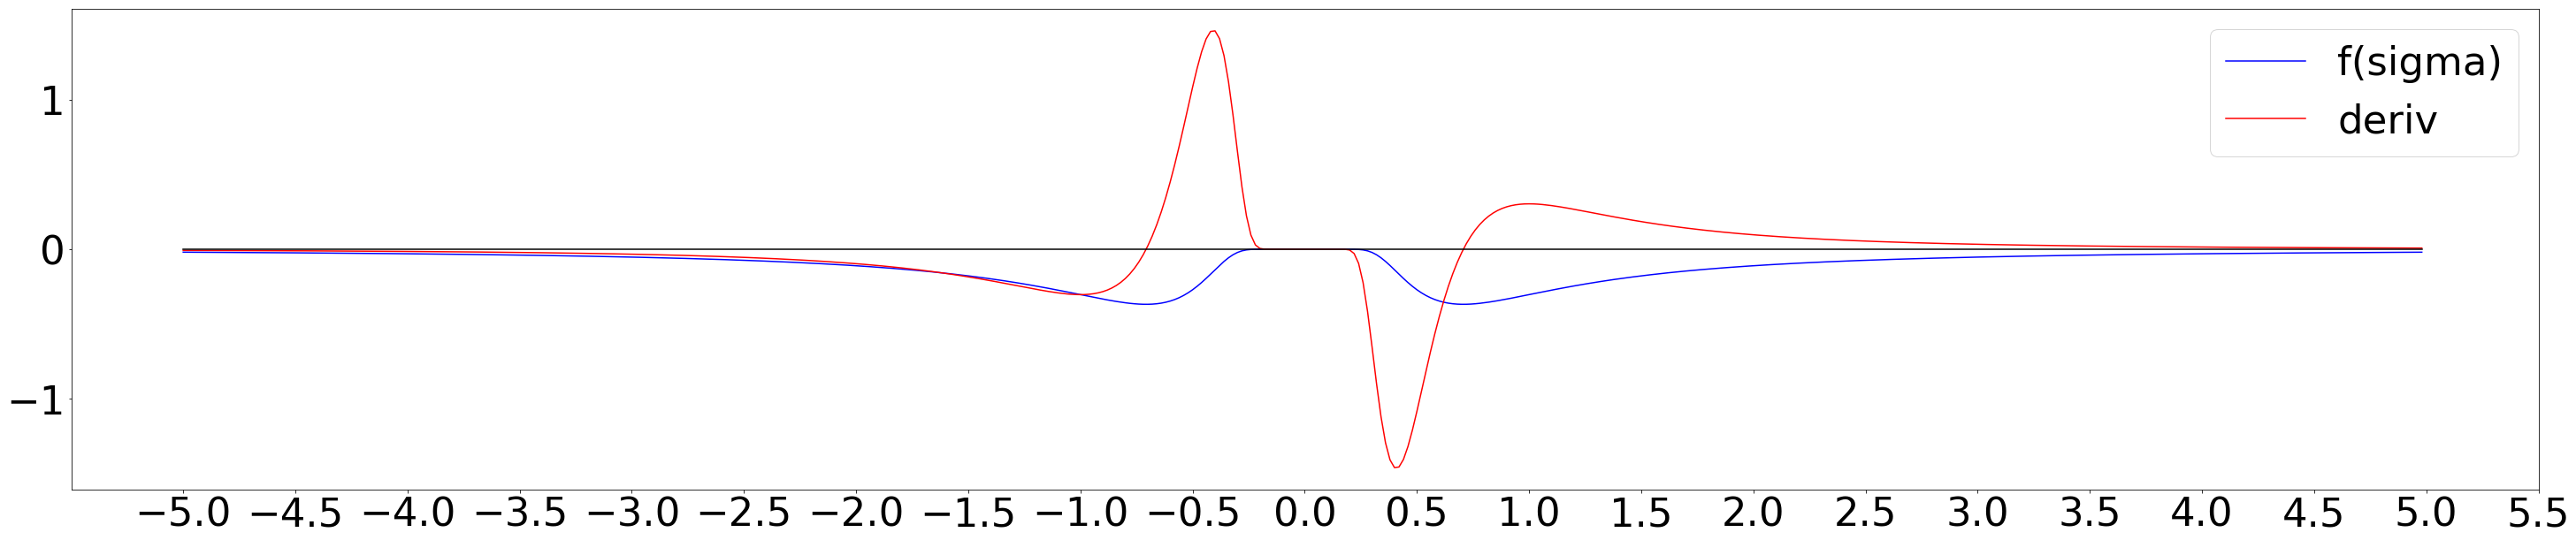

In [8]:
x = (np.arange(-5,5,0.02))

ax = plt.figure(figsize=(50,10))
plt.plot(x, func(x),c="b", label="f(sigma)")
plt.plot(x, deriv(x), c="r", label="deriv")

plt.plot(x,0*x , c="black")
ax = plt.xticks(np.arange(min(x), max(x)+1, .5))
plt.legend()
plt.show()


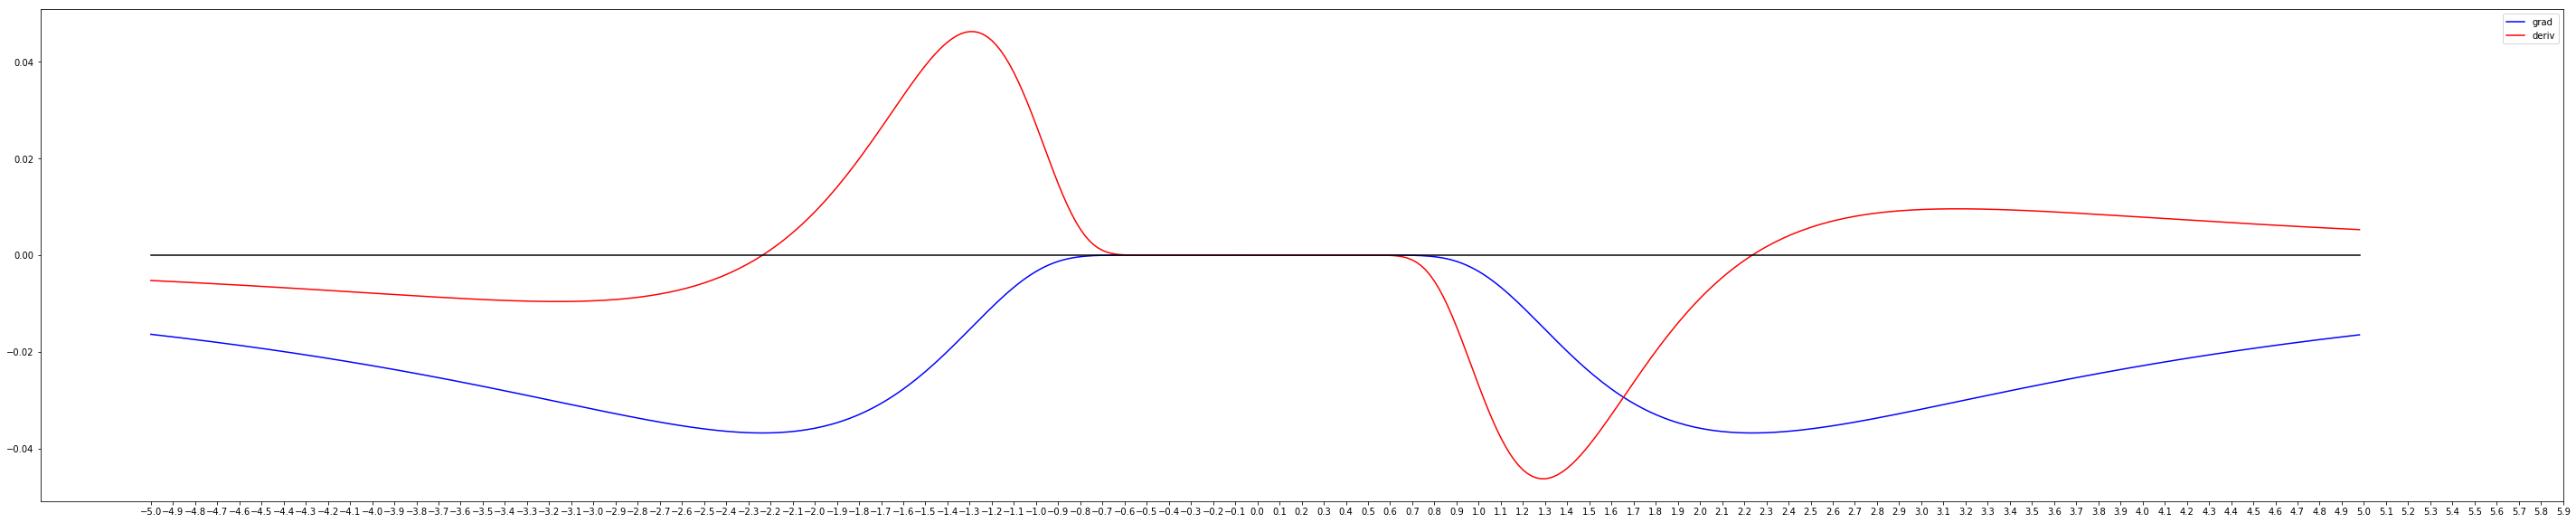

In [121]:
const = 10

func = lambda x: 1/(-2*x**2) * np.exp(-const/(2*x**2))
deriv= lambda x: (-const+2*x**2)/(2*x**5) * np.exp(-const/(2*x**2))
x = (np.arange(-5,5,0.02))

ax = plt.figure(figsize=(50,10))
plt.plot(x, func(x),c="b", label="grad")
plt.plot(x, deriv(x), c="r", label="deriv")

plt.plot(x,0*x , c="black")
ax = plt.xticks(np.arange(min(x), max(x)+1, .1))
plt.legend()
plt.show()